# Natural Language Processing with TensorFlow

**In this notebook I will be using TensorFlow to process tweets and predict whether they pertain to a disaster or not.**

---

**Notes**  

- This notebook was created using the guide found [here](https://www.kaggle.com/code/calebreigada/tensorflow-natural-language-processing-guide/notebook). 
- I do not take any credit for the methods displayed, as I am following a guide and simply applying the techniques there to a different set of data.
- As suggested in the guide linked, prior research was done on unfamiliar topics to help understand the work flow better. I am certainly not an expert in this topic and am still learning.

---


# Loading the Data

For this notebook, I will be using the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started) dataset. This set is a great way to get started with NLP models and applications, and understand how machine learning algorithms can be used on non-numeric data through data transformations.  

The dataset contains tweets that fall into one of two conditions: either they are discussing a real life disaster, or they are not. This may seem like a fairly easy thing to discern, but as listed on the dataset's page, there are instances where based on wording alone, it can be difficult to identify the correct category. 

In [1]:
# Importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import re
import string
from nltk.corpus import stopwords

In [2]:
# Reading in data
train_full = pd.read_csv("../input/nlp-getting-started/train.csv")
test_full = pd.read_csv("../input/nlp-getting-started/test.csv")

train_text = train_full["text"]
train_labels = train_full["target"]

test_text = test_full["text"]
test_labels = test_full["text"]

Now that our data has been loaded, let's take a quick look at some tweet examples. We'll investigate a random sample of the training data to see what a disaster-related tweet looks like as well as a non-disaster-related tweet.

In [3]:
# Print sample observations from training data
print("Example training data observations")
print("---------------\n")
np.random.seed(777)
for i in np.random.randint(0, high = 100, size = 10):
    tweet_type = "Disaster" if train_labels[i] == 1 else "Non-disaster"
    print("Tweet classifier:", tweet_type)
    print("Tweet:", train_text[i], "\n")

Example training data observations
---------------

Tweet classifier: Non-disaster
Tweet: Building the perfect tracklist to life leave the streets ablaze 

Tweet classifier: Disaster
Tweet: How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd 

Tweet classifier: Disaster
Tweet: Barbados #Bridgetown JAMAICA ÛÒ Two cars set ablaze: SANTA CRUZ ÛÓ Head of the St Elizabeth Police Superintende...  http://t.co/wDUEaj8Q4J 

Tweet classifier: Disaster
Tweet: RT nAAYf: First accident in years. Turning onto Chandanee Magu from near MMA. Taxi rammed into me while I was halfway turned. Everyone confÛ_ 

Tweet classifier: Non-disaster
Tweet: First night with retainers in. It's quite weird. Better get used to it; I have to wear them every single night for the next year at least. 

Tweet classifier: Non-disaster
Tweet: #stlouis #caraccidentlawyer Speeding Among Top Causes of Teen Accidents https://t.co/k4zoMOF319 

Great! This printout gives us good insight into how the tweets may vary in their wording, but also how certain words may appear to be disaster related, but also come up in non-disaster tweets. For example, the 8th tweet listed above contains the word "ablaze". This would typically be associated with a disaster related tweet talking about a fire. However, here we see it being used in a non-disaster tweet. This sort of occurance is an obstacle in predicting the tweets sentiment, and represents just one type of challenge faced when performing NLP.

Other observations:
- Many of the tweets contain links to images, something to consider when cleaning the text
- There are a couple unusual characters in the tweet, such as "ÛÒ" and "Û_"
- Hashtags may need to get cleaned out to ensure the words following the tag are read properly

# Cleaning the data

Before we transform the text data into a numerical representation, we first want to clean the text to be as consistent and easy to transform as possible. That means unifying words with various capitalization, removing symbols such as hashtags to ensure those words are grouped properly, and parsing links to images in a way that preserves the information's integrity. 

In [4]:
# Transforming all text to lowercase
train_text = train_text.str.lower()
test_text = test_text.str.lower()

In [5]:
# Removing unicode characters
for i in range(train_text.shape[0]):
    train_text[i] = train_text[i].encode("ascii", "ignore").decode()

for i in range(test_text.shape[0]):
    test_text[i] = test_text[i].encode("ascii", "ignore").decode()

In [6]:
# Creating a function that will clean the list of strings
stop_words = stopwords.words("english")

def text_preprocess(x):
    x = x.lower()
    x = " ".join([word for word in x.split(" ") if word not in stop_words])
    x = x.encode("ascii", "ignore").decode()
    x = re.sub(r"@\S+", " ", x)
    x = re.sub(r"#\S+", " ", x)
    x = re.sub(r"\'\w+", "", x)
    x = re.sub('[%s]' % re.escape(string.punctuation), " ", x)
    x = re.sub(r"\w*\d+\w*", "", x)
    x = re.sub(r"\s{2,}", " ", x)
    return x

In [7]:
train_text = train_text.apply(text_preprocess)
test_text = test_text.apply(text_preprocess)

Now that we have applied the preprocessing function to the text, let's take a look at how our tweets have changed.

In [8]:
# Print cleaned text examples from training set
print("Example cleaned training data observations")
print("---------------\n")
np.random.seed(777)
for i in np.random.randint(0, high = 100, size = 10):
    tweet_type = "Disaster" if train_labels[i] == 1 else "Non-disaster"
    print("Tweet classifier:", tweet_type)
    print("Tweet:", train_text[i], "\n")

Example cleaned training data observations
---------------

Tweet classifier: Non-disaster
Tweet: building perfect tracklist life leave streets ablaze 

Tweet classifier: Disaster
Tweet: west burned thousands wildfires ablaze alone http t co http t co  

Tweet classifier: Disaster
Tweet: barbados jamaica two cars set ablaze santa cruz head st elizabeth police superintende http t co  

Tweet classifier: Disaster
Tweet: rt naayf first accident years turning onto chandanee magu near mma taxi rammed halfway turned everyone conf  

Tweet classifier: Non-disaster
Tweet: first night retainers in quite weird better get used it wear every single night next year least  

Tweet classifier: Non-disaster
Tweet:  speeding among top causes teen accidents https t co https t co car accident tee  

Tweet classifier: Non-disaster
Tweet: like pasta  

Tweet classifier: Non-disaster
Tweet: ablaze lord d 

Tweet classifier: Disaster
Tweet:  accident property damage piner rd horndale dr 

Tweet classifier: D

We can see that the tweets are much more uniform in their formatting now. No more unusual characters or capitalization discrepencies.

It is important to note that we left in the "https" tag in hopes that doing so would preserve some information that the tag may hold. To investigate if we still think this is the right call, let's take a look at the number of disaster tweets containing "https" versus non-disaster tweets that also contain the string.

<AxesSubplot:>

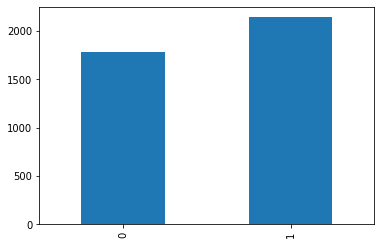

In [9]:
# Exploring counts of https string
train_labels[train_text.str.contains("https | http")]\
.value_counts().sort_index().plot.bar(x = "Target Value", y = "Number of Occurences")

This simple bar chart tells us that if a tweet contains the "https" or "http" string, it is slightly more likely that the tweet in question is a disaster related tweet. This seems useful, so we will keep the strings in there rather than filter them out.

# Text to Numeric Transformation